In [2]:
import numpy as np
from pyproj import Transformer
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import gc

In [3]:

# %% Classes definition
class well_data:
    def __init__(self, well_ids, well_x_coords, well_y_coords, well_wtd, observation_dates, Region):
        self.well_ids = well_ids
        self.well_x_coords = well_x_coords
        self.well_y_coords = well_y_coords
        self.well_wtd = well_wtd
        self.observation_dates = observation_dates
        self.Region = Region

    def coordinate_transformation(self, x_coord_before, y_coord_before, CS_origin, CS_target):
        transformer = Transformer.from_crs(CS_origin, CS_target)
        lon, lat = transformer.transform(x_coord_before, y_coord_before)
        self.well_x_coords = lon
        self.well_y_coords = lat

    def average_wtd(self):
        unique_wells = np.unique(self.well_ids)
        x_coords = np.zeros(len(unique_wells))
        y_coords = np.zeros(len(unique_wells))
        avg_wtd = np.zeros(len(unique_wells))
        region = [self.Region for _ in range(len(unique_wells))]
        for i, well in enumerate(unique_wells):
            avg_wtd[i] = np.mean(self.well_wtd[self.well_ids == well])
            x_coords[i] = self.well_x_coords[self.well_ids == well][0]
            y_coords[i] = self.well_y_coords[self.well_ids == well][0]
        summary_data = pd.DataFrame({'Well ID': unique_wells, 'X_54012': x_coords, 'Y_54012': y_coords, 'Average WTD': avg_wtd, 'Region': region})
        return summary_data
    
    def standard_deviation_wtd(self):
        unique_wells = np.unique(self.well_ids)
        x_coords = np.zeros(len(unique_wells))
        y_coords = np.zeros(len(unique_wells))
        std_wtd = np.zeros(len(unique_wells))
        region = [self.Region for _ in range(len(unique_wells))]
        for i, well in enumerate(unique_wells):
            std_wtd[i] = np.std(self.well_wtd[self.well_ids == well])
            x_coords[i] = self.well_x_coords[self.well_ids == well][0]
            y_coords[i] = self.well_y_coords[self.well_ids == well][0]
        summary_data = pd.DataFrame({'Well ID': unique_wells, 'X_54012': x_coords, 'Y_54012': y_coords, 'Standard Deviation WTD': std_wtd, 'Region': region})
        return summary_data
    
    def data_frame(self):
        data = pd.DataFrame({'Well ID': self.well_ids, 'X_54012': self.well_x_coords, 'Y_54012': self.well_y_coords, 'WTD': self.well_wtd, 'Date': self.observation_dates})
        return data
    
    def clean_data(self):
        measurements = self.well_wtd
        new_measurements = np.copy(measurements)
        for n_measurement, measurement in enumerate(measurements):
            if isinstance(measurement, str):
                measurement = measurement.strip()  # Remove any surrounding whitespace
                # Handle strings starting with '<' or '>'
                if measurement.startswith('<') or measurement.startswith('>'):
                    remaining = measurement[1:].strip()
                    
                # Check for '-' after the sign
                    if remaining.startswith('-'):
                        new_measurements[n_measurement] = 0
                    else:
                        if ',' in remaining:
                            remaining = remaining.replace(',', '.')
                        new_measurements[n_measurement] = float(remaining)
                else:
                    # Convert plain string to float if it's a measurementid number
                    new_measurements[n_measurement] = float(measurement.replace(',', '.'))
        self.well_wtd = new_measurements

    def keep_good_data(self):
            measurements = self.well_wtd
            new_measurements = np.copy(measurements)
            for n_measurement, measurement in enumerate(measurements):
                if isinstance(measurement, str):
                    measurement = measurement.strip()  # Remove any surrounding whitespace
                    # Handle strings starting with '<' or '>'
                    if measurement.startswith('<') or measurement.startswith('>'):
                        new_measurements[n_measurement] = -999
                    else:
                        # Convert plain string to float if it's a measurementid number
                        new_measurements[n_measurement] = float(measurement.replace(',', '.'))
            self.well_wtd = new_measurements[new_measurements != -999]
            self.well_ids = self.well_ids[new_measurements != -999]
            self.well_x_coords = self.well_x_coords[new_measurements != -999]
            self.well_y_coords = self.well_y_coords[new_measurements != -999]
            self.observation_dates = self.observation_dates[new_measurements != -999]

class anagrafica:
    def __init__(self, well_ids, well_x_coords, well_y_coords):
        self.well_ids = well_ids
        self.well_x_coords = well_x_coords
        self.well_y_coords = well_y_coords

    def transform_coords(self, x_coord_before, y_coord_before, CS_origin, CS_target):
        transformer = Transformer.from_crs(CS_origin, CS_target)
        lon, lat = transformer.transform(x_coord_before, y_coord_before)
        self.well_x_coords = lon
        self.well_y_coords = lat

In [4]:
# %% LOMBARDY
provinces_lombardy = ['Bergamo', 'Brescia', 'Como', 'Cremona', 'Lecco', 'Lodi', 'Mantova', 'Milano', 'Monza', 'Sondrio', 'Pavia', 'Varese']

all_data_lombardy = pd.DataFrame()
for province in provinces_lombardy:
    all_data_lombardy = pd.concat([all_data_lombardy, pd.read_excel(f'Lombardia/Dati quantitativi {province}_2000_2021.xlsx')])

all_data_lombardy = all_data_lombardy[all_data_lombardy['TIPO'] == 'PIEZOMETRO']
all_data_lombardy = well_data(all_data_lombardy['CODICE PUNTO'], all_data_lombardy['X_WGS84'], all_data_lombardy['Y_WGS84'], all_data_lombardy['MISURA SOGGIACENZA [m]'], all_data_lombardy['DATA'], 'Lombardy')

del provinces_lombardy, province
gc.collect()

all_data_lombardy.coordinate_transformation(all_data_lombardy.well_x_coords, all_data_lombardy.well_y_coords, 'epsg:32632', "+proj=eck4 +lon_0=0 +datum=WGS84 +units=m no_defs")

average_wtd_lombardy = all_data_lombardy.average_wtd()
std_wtd_lombardy = all_data_lombardy.standard_deviation_wtd()
transient_wtd_lombardy = all_data_lombardy.data_frame()



In [7]:
piezometers = ['PO0140290R0001',
    'PO014029NR0001',
    'PO0150850U0263',
    'PO0170520UC573',
    'PO0170720U0253',
    'PO0170750U0001',
    'PO0171130UC595',
    'PO0171140UC023',
    'PO0171640UC596',
    'PO0171880UC033',
    'PO018039NR0001',
    'PO0190710U0713',
    'PO020001NU0001',
    'PO0200720R0001',
    'PO0970390U0003',
    'PO1080210U0002',
    'PO015062NR0071']


C:\Users\Leonardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


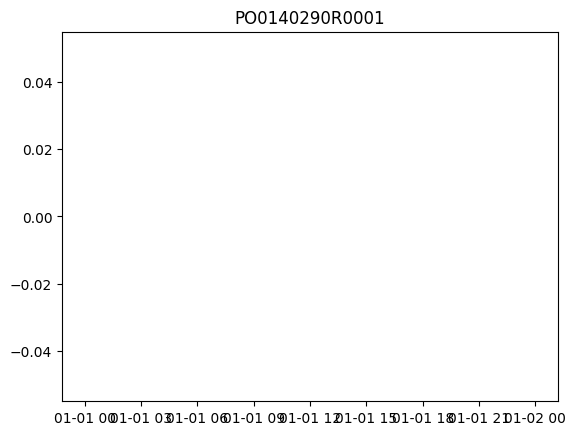

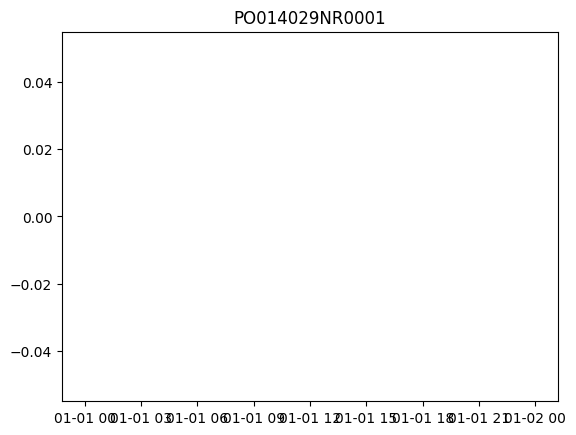

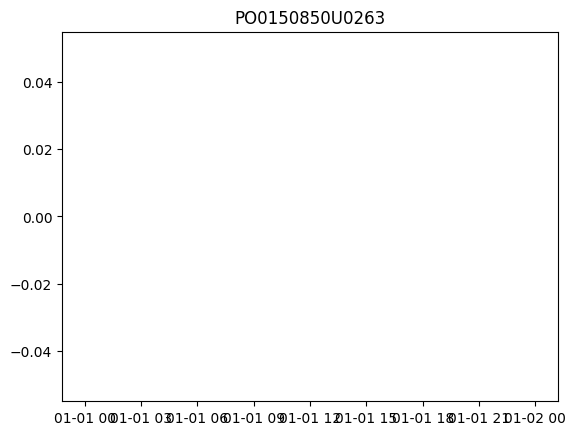

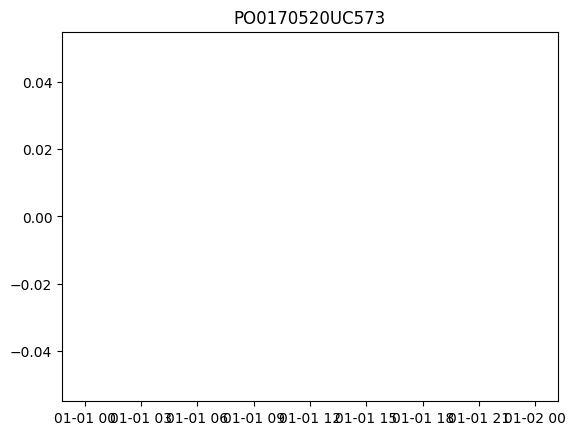

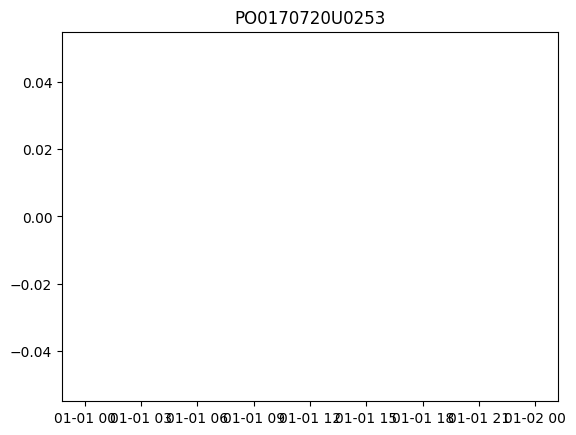

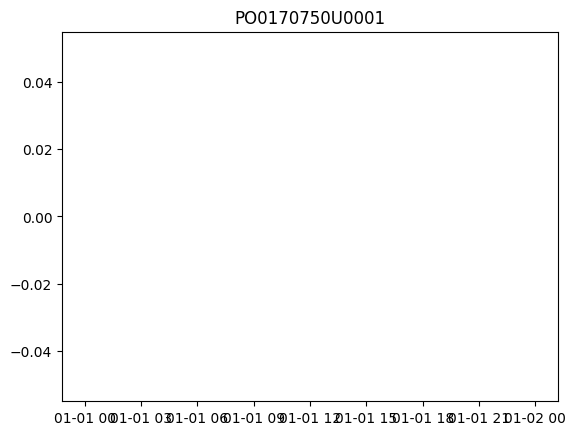

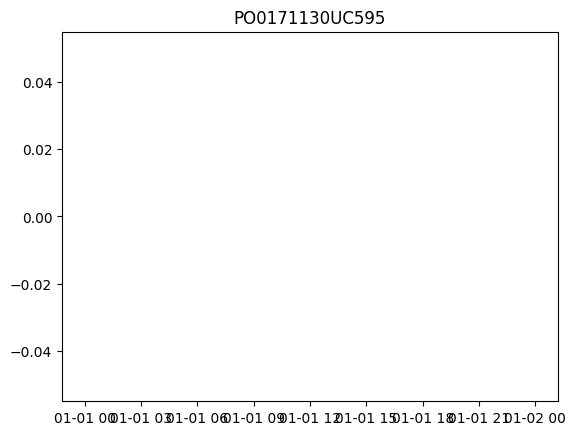

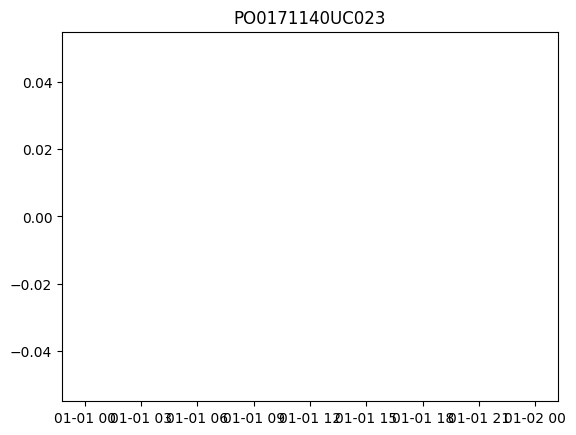

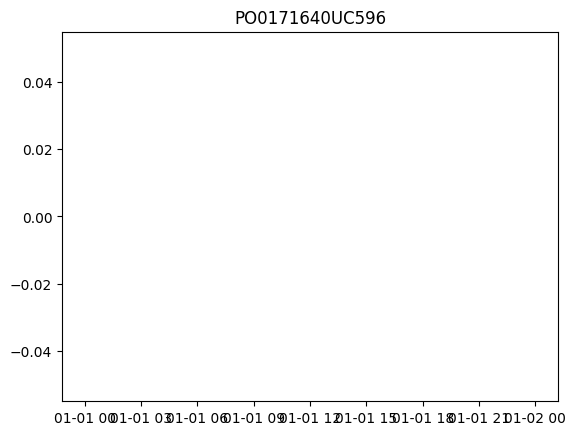

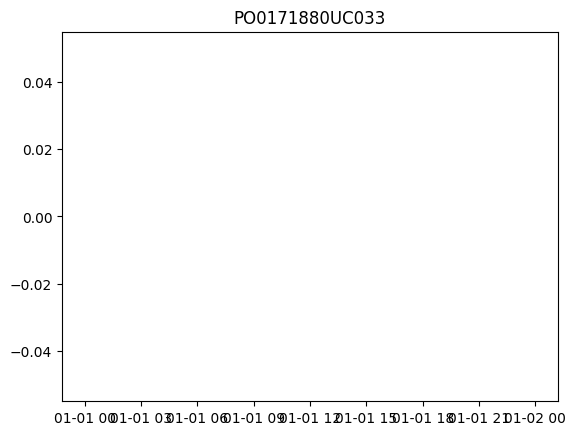

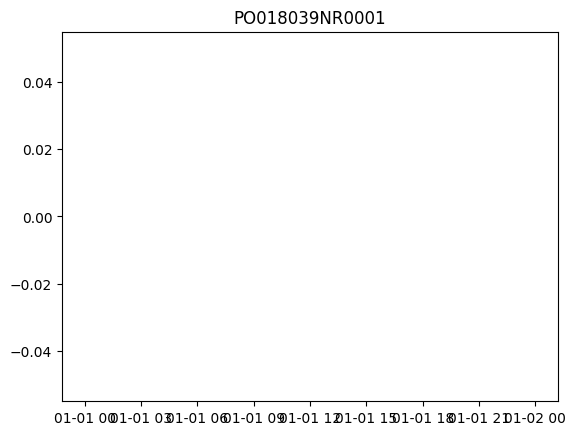

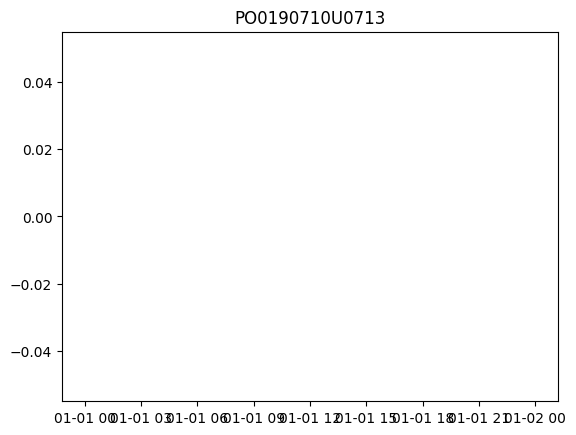

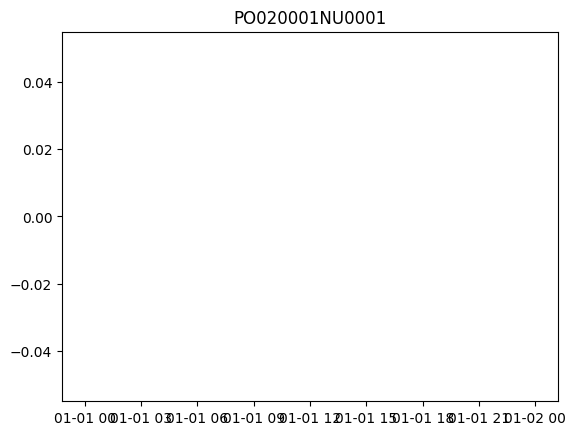

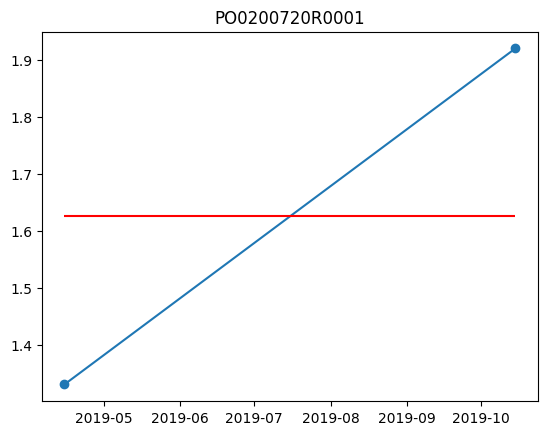

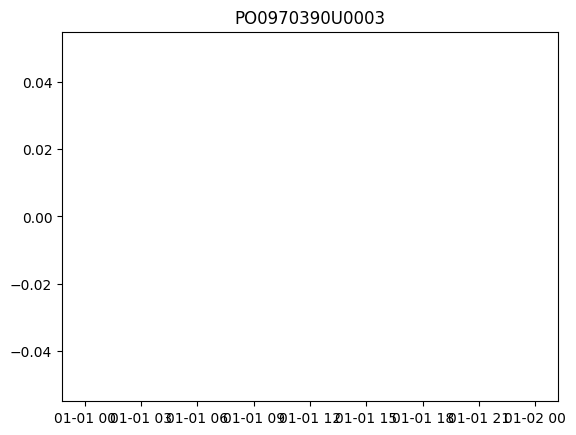

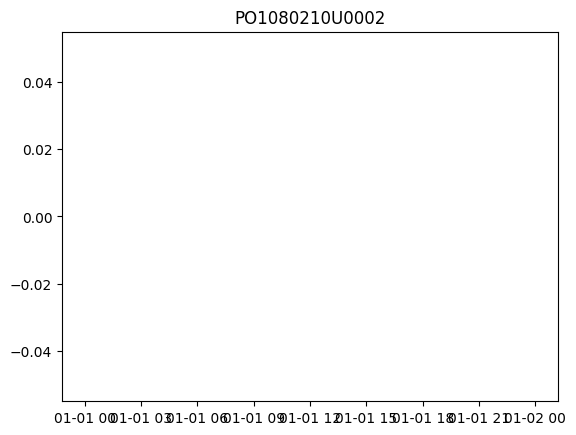

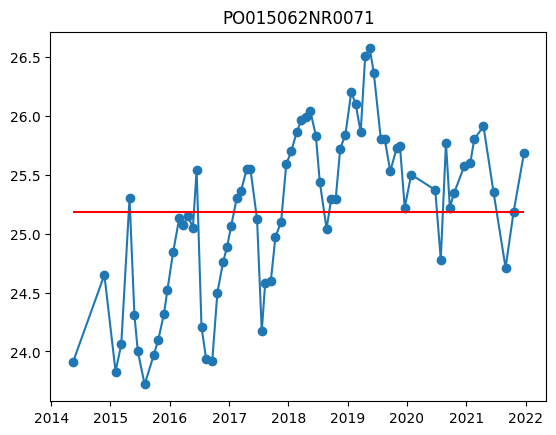

In [8]:
for well_id in piezometers:

# well_id = piezometers[0]
	fig = plt.figure()
	plt.plot(transient_wtd_lombardy[transient_wtd_lombardy['Well ID'] == well_id]['Date'], transient_wtd_lombardy[transient_wtd_lombardy['Well ID'] == well_id]['WTD'], 'o-')
	plt.hlines(y = np.mean(transient_wtd_lombardy[transient_wtd_lombardy['Well ID'] == well_id]['WTD']), xmin = transient_wtd_lombardy[transient_wtd_lombardy['Well ID'] == well_id]['Date'].min(), xmax = transient_wtd_lombardy[transient_wtd_lombardy['Well ID'] == well_id]['Date'].max(), color = 'r')
	plt.title(well_id)
	# plt.plot(transient_wtd_lombardy[transient_wtd_lombardy['Well ID'] == well_id]['WTD'])